## Imports

In [4]:
import argparse
import os
import time
import sys
import random
import gc
import json
import pickle
from collections import Counter
from multiprocessing import Pool
from pathlib import Path

from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA, PLSRegression as PLS
from IPython.display import Video, HTML
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

from pyriemann.estimation import XdawnCovariances, BlockCovariances, Covariances
from pyriemann.tangentspace import TangentSpace

manualSeed = 111
SEED = manualSeed
random.seed(manualSeed)

DATA_PATH = '/data/vladimiroved/realWorldTableTennis'
FREQ = 250

## Collect data

In [5]:
!mkdir -p causal-lag-data

In [5]:
PARTICIPANT_CHANNELS = [
    'Fp1', 'AFp1', 'AFz', 'AF3', 'AF7', 'AFF5h', 'AFF1h', 'F1', 'F3',
    'F5', 'F7', 'F9', 'FFT9h', 'FFT7h', 'FFC5h', 'FFC3h', 'FFC1h',
    'FCz', 'FC1', 'FC3', 'FC5', 'FT7', 'FT9', 'FTT9h', 'FTT7h',
    'FCC5h', 'FCC3h', 'FCC1h', 'C1', 'C3', 'C5', 'T7', 'TTP7h',
    'CCP5h', 'CCP3h', 'CCP1h', 'CP1', 'CP3', 'CP5', 'TP7', 'TPP9h',
    'TPP7h', 'CPP5h', 'CPP3h', 'CPP1h', 'P1', 'P3', 'P5', 'P7',
    'PPO5h', 'PPO1h', 'POz', 'PO3', 'PO7', 'PPO9h', 'O1', 'POO1',
    'OI1h', 'Iz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'FTT10h', 'FTT8h',
    'FCC6h', 'FCC4h', 'FCC2h', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10',
    'FFT10h', 'FFT8h', 'FFC6h', 'FFC4h', 'FFC2h', 'Fz', 'F2', 'F4',
    'F6', 'F8', 'F10', 'AFF6h', 'AFF2h', 'AF4', 'AF8', 'FP2', 'AFp2',
    'Oz', 'OI2h', 'POO10h', 'O2', 'POO2', 'PO4', 'PO8', 'PPO10h',
    'PPO6h', 'PPO2h', 'Pz', 'P2', 'P4', 'P6', 'P8', 'TPP10h', 'TPP8h',
    'CPP6h', 'CPP4h', 'CPP2h', 'CP2', 'CP4', 'CP6', 'TP8', 'TTP8h',
    'CCP6h', 'CCP4h', 'CCP2h', 'N-Fp1', 'N-AFp1', 'N-AFz', 'N-AF3',
    'N-AF7', 'N-AFF5h', 'N-AFF1h', 'N-F1', 'N-F3', 'N-F5', 'N-F7',
    'N-F9', 'N-FFT9h', 'N-FFT7h', 'N-FFC5h', 'N-FFC3h', 'N-FFC1h',
    'N-FCz', 'N-FC1', 'N-FC3', 'N-FC5', 'N-FT7', 'N-FT9', 'N-FTT9h',
    'N-FTT7h', 'N-FCC5h', 'N-FCC3h', 'N-FCC1h', 'N-C1', 'N-C3', 'N-C5',
    'N-T7', 'N-TTP7h', 'N-CCP5h', 'N-CCP3h', 'N-CCP1h', 'N-CP1',
    'N-CP3', 'N-CP5', 'N-TP7', 'N-TPP9h', 'N-TPP7h', 'N-CPP5h',
    'N-CPP3h', 'N-CPP1h', 'N-P1', 'N-P3', 'N-P5', 'N-P7', 'N-PPO5h',
    'N-PPO1h', 'N-POz', 'N-PO3', 'N-PO7', 'N-PPO9h', 'N-O1', 'N-POO1',
    'N-OI1h', 'N-Iz', 'N-Cz', 'N-C2', 'N-C4', 'N-C6', 'N-T8',
    'N-FTT10h', 'N-FTT8h', 'N-FCC6h', 'N-FCC4h', 'N-FCC2h', 'N-FC2',
    'N-FC4', 'N-FC6', 'N-FT8', 'N-FT10', 'N-FFT10h', 'N-FFT8h',
    'N-FFC6h', 'N-FFC4h', 'N-FFC2h', 'N-Fz', 'N-F2', 'N-F4', 'N-F6',
    'N-F8', 'N-F10', 'N-AFF6h', 'N-AFF2h', 'N-AF4', 'N-AF8', 'N-FP2',
    'N-AFp2', 'N-Oz', 'N-OI2h', 'N-POO10h', 'N-O2', 'N-POO2', 'N-PO4',
    'N-PO8', 'N-PPO10h', 'N-PPO6h', 'N-PPO2h', 'N-Pz', 'N-P2', 'N-P4',
    'N-P6', 'N-P8', 'N-TPP10h', 'N-TPP8h', 'N-CPP6h', 'N-CPP4h',
    'N-CPP2h', 'N-CP2', 'N-CP4', 'N-CP6', 'N-TP8', 'N-TTP8h',
    'N-CCP6h', 'N-CCP4h', 'N-CCP2h', 'LISCM', 'LSSCM', 'LSTrap',
    'LITrap', 'CGY-x', 'CGY-y', 'CGY-z', 'RITrap', 'RISCM', 'RSSCM',
    'RSTrap', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z',
    'NWR-x', 'NWR-y', 'NWR-z', 'Participant_Paddle_Acc_X(g)',
    'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)'
]
EPS = 1e-3
SFREQ = 250
SUB_IDS = ['0' * (n < 10) + str(n) for n in range(1, 26)]
data_sample_arr = []

np.random.seed(SEED)

for SUB_ID in tqdm(SUB_IDS):
    eeg_dirname = os.path.join(DATA_PATH, f'sub-{SUB_ID}', 'eeg/')
    channels_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_channels.tsv', sep='\t')
    raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
    
    eeg_channels = channels_df[channels_df['type'] == 'EEG']['name'].tolist()
    emg_channels = channels_df[channels_df['type'] == 'EMG']['name'].tolist()
    misc_channels = channels_df[channels_df['type'] == 'MISC']['name'].tolist()
    
    # Set channel types
    channel_types = {}
    for ch in raw_eeg.ch_names:
        if ch in eeg_channels:
            channel_types[ch] = 'eeg'
        elif ch in emg_channels:
            channel_types[ch] = 'emg'
        else:
            channel_types[ch] = 'misc'  # Includes IMU and other sensors
    
    raw_eeg.set_channel_types(channel_types)

    # Take a random start moment from 10th to 50th minute
    start_idx = np.random.randint(low=250*10*60, high=250*50*60)
    # end_idx = start_idx + 1 minute
    end_idx = start_idx + 250 * 60
    
    data_sample = raw_eeg.pick_channels(PARTICIPANT_CHANNELS).get_data(start=start_idx, stop=end_idx)

    data_sample_arr.append(data_sample)
    
    gc.collect()

In [7]:
signals_slices_npy = np.stack(data_sample_arr)
np.save('causal-lag-data/signals_sample.npy', signals_slices_npy)
signals_slices_npy.shape

(25, 261, 15000)

In [6]:
signals_slices_npy = np.load('../data/causal-lag-data/signals_sample.npy')

### Transform data

In [9]:
idx_noise_start = np.where(np.char.startswith(PARTICIPANT_CHANNELS, 'N-'))[0][0]
scalp = signals_slices_npy[:, :idx_noise_start, :]
noise = signals_slices_npy[:, idx_noise_start:2*idx_noise_start, :]
eeg = scalp - noise

imu_names = (
    'LISCM', 'LSSCM', 'LSTrap', 'LITrap',
    'RITrap', 'RISCM', 'RSSCM', 'RSTrap',
    'Participant_Paddle_Acc_X(g)',
    'Participant_Paddle_Acc_Y(g)',
    'Participant_Paddle_Acc_Z(g)'
)
imu_idx = np.array([
    PARTICIPANT_CHANNELS.index(nm) for nm in imu_names
])
imu = signals_slices_npy[:, imu_idx, :]
imu_idx -= 2*idx_noise_start

In [11]:
def zscore(arr, mean=None, std=None):
    # arr.shape = (K_EVENTS, K_CHANNELS, TIMESTEPS)
    arr_mean = arr.mean(axis=(0, 2), keepdims=True) if mean is None else mean.reshape(1, -1, 1)
    arr_std = arr.std(axis=(0, 2), keepdims=True) if std is None else std.reshape(1, -1, 1)
    return (arr - arr_mean) / arr_std


PATH_MACHINE = "../data/human-player/signals-stats/"

eeg_mean = np.load(os.path.join(PATH_MACHINE, "eeg_mean.npy"))
eeg_std = np.load(os.path.join(PATH_MACHINE, "eeg_std.npy"))
imu_mean = np.load(os.path.join(PATH_MACHINE, "imu_mean.npy"))
imu_std = np.load(os.path.join(PATH_MACHINE, "imu_std.npy"))

imu_mean = imu_mean[imu_idx]
imu_std = imu_std[imu_idx]

eeg = zscore(eeg, eeg_mean, eeg_std)
imu = zscore(imu, imu_mean, imu_std)

## Define causal lag $\tau$

### Covariance

In [37]:
%%time
def imu_stats(arr):
    # arr: (N, C, T) → output shape (N, (C+1)*4)
    acceleration = np.sqrt(np.sum(np.square(arr[:, -3:, :]), axis=1, keepdims=True))
    arr_stacked = np.concatenate((arr, acceleration), axis=1)
    mean = arr_stacked.mean(axis=2)
    std = arr_stacked.std(axis=2)
    mx = arr_stacked.max(axis=2)
    mn = arr_stacked.min(axis=2)
    return np.concatenate([mean, std, mx, mn], axis=1)
    
window_size = 0.3   # seconds  
step_size   = 0.1   # seconds  
sfreq       = 250   # Hz

win_len = int(window_size * sfreq)  # → 75 samples  
step    = int(step_size   * sfreq)  # → 25 samples  
starts  = np.arange(0, eeg.shape[2] - win_len + 1, step)
n_win   = len(starts)

# pre‐allocate  
#   cov_ts:   (n_events, n_windows, n_chans, n_chans)  
#   imu_ts:   (n_events, n_windows, (n_imu+1)*4)  
cov_ts = np.zeros((eeg.shape[0], n_win, eeg.shape[1], eeg.shape[1]), dtype=np.float32)  
imu_ts = np.zeros((imu.shape[0], n_win, (imu.shape[1]+1)*4),         dtype=np.float32)

cov_est = Covariances(estimator='oas')

for w, start in tqdm(enumerate(starts), total=len(starts)):
    stop = start + win_len

    # --- EEG covariance for this window ---  
    seg_eeg = eeg[:, :, start:stop]           # (N_events, K_eeg, win_len)  
    cov_ts[:, w, :, :] = cov_est.transform(seg_eeg)

    # --- IMU stats for this window ---  
    seg_imu = imu[:, :, start:stop]           # (N_events, K_imu, win_len)  
    imu_ts[:, w, :] = imu_stats(seg_imu)      # (mean, std, max, min for each ch + accel)  


  0%|          | 0/598 [00:00<?, ?it/s]

CPU times: user 10min 47s, sys: 24min 24s, total: 35min 12s
Wall time: 1min 48s


In [38]:
%%time
def scan_lagged_cca(X: np.ndarray, Y: np.ndarray, lag_set: tuple, model: str = 'cca'):
    """Return τ⋆ and its first canonical correlation."""
    best_tau, best_rho = None, -np.inf
    T = len(X)
    for tau in lag_set:
        Xτ = X[:T - tau] if tau else X
        Yτ = Y[tau:] if tau else Y
        if model == 'cca':
            cca = CCA(n_components=1, scale=True)
        else:
            cca = PLS(n_components=1, scale=True)
        u, v = cca.fit_transform(Xτ, Yτ)
        rho = np.corrcoef(u[:, 0], v[:, 0])[0, 1]
        if rho > best_rho:
            best_tau, best_rho = tau, rho

    return best_tau, best_rho


lag_set = np.arange(10)
partial_scan_lagged_cca = partial(scan_lagged_cca, lag_set=lag_set, model='pls')

with Pool() as pool:
    tau_arr = list(
        tqdm(
            pool.starmap(
                partial_scan_lagged_cca,
                zip(cov_ts.reshape(len(cov_ts), n_win, -1), imu_ts)
            ),
            total=len(cov_ts)
        )
    )

  0%|          | 0/25 [00:00<?, ?it/s]

CPU times: user 485 ms, sys: 1.74 s, total: 2.22 s
Wall time: 33.7 s


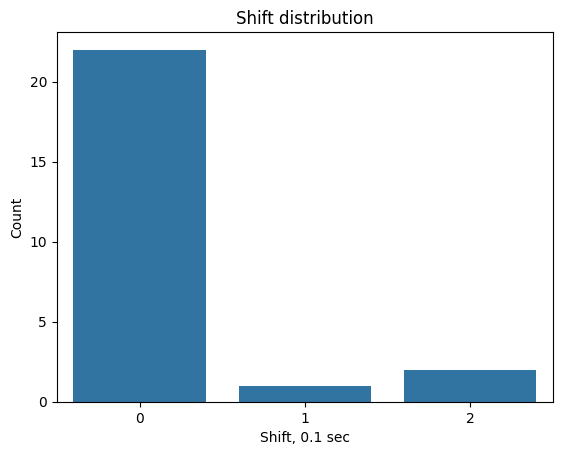

In [39]:
sns.barplot(Counter(list(map(lambda x: x[0], tau_arr))))
plt.xlabel("Shift, 0.1 sec")
plt.ylabel("Count")
plt.title("Shift distribution")
plt.show()

In [40]:
del cov_ts, imu_ts

### Covariance + TangentSpace

In [41]:
%%time
def imu_stats(arr):
    # arr: (N, C, T) → output shape (N, (C+1)*4)
    acceleration = np.sqrt(np.sum(np.square(arr[:, -3:, :]), axis=1, keepdims=True))
    arr_stacked = np.concatenate((arr, acceleration), axis=1)
    mean = arr_stacked.mean(axis=2)
    std = arr_stacked.std(axis=2)
    mx = arr_stacked.max(axis=2)
    mn = arr_stacked.min(axis=2)
    return np.concatenate([mean, std, mx, mn], axis=1)
    
window_size = 0.3   # seconds  
step_size   = 0.1   # seconds  
sfreq       = 250   # Hz

win_len = int(window_size * sfreq)  # → 75 samples  
step    = int(step_size   * sfreq)  # → 25 samples  
starts  = np.arange(0, eeg.shape[2] - win_len + 1, step)
n_win   = len(starts)

# pre‐allocate  
#   cov_ts:   (n_events, n_windows, n_chans, n_chans)  
#   imu_ts:   (n_events, n_windows, (n_imu+1)*4)  
cov_ts     = np.zeros((eeg.shape[0], n_win, eeg.shape[1]*(eeg.shape[1]+1)//2), dtype=np.float32)  
imu_ts     = np.zeros((imu.shape[0], n_win, (imu.shape[1]+1)*4),         dtype=np.float32)

pipe = Pipeline([('cov', Covariances(estimator='oas')), ('tangent', TangentSpace())])
setattr(pipe['tangent'], "reference_", Covariances('oas').transform(eeg[0:1])[0])

for w, start in tqdm(enumerate(starts), total=len(starts)):
    stop = start + win_len

    # --- EEG covariance for this window ---  
    seg_eeg = eeg[:, :, start:stop]           # (N_events, K_eeg, win_len)  
    cov_ts[:, w, :] = pipe.transform(seg_eeg)

    # --- IMU stats for this window ---  
    seg_imu = imu[:, :, start:stop]           # (N_events, K_imu, win_len)  
    imu_ts[:, w, :] = imu_stats(seg_imu)      # (mean, std, max, min for each ch + accel)  


  0%|          | 0/598 [00:00<?, ?it/s]

CPU times: user 24min 53s, sys: 55min 11s, total: 1h 20min 4s
Wall time: 5min 22s


In [42]:
%%time
lag_set = np.arange(10)
partial_scan_lagged_cca = partial(scan_lagged_cca, lag_set=lag_set, model='pls')

with Pool() as pool:
    tau_arr_2 = list(
        tqdm(
            pool.starmap(
                partial_scan_lagged_cca,
                zip(cov_ts.reshape(len(cov_ts), n_win, -1), imu_ts)
            ),
            total=len(cov_ts)
        )
    )

  0%|          | 0/25 [00:00<?, ?it/s]

CPU times: user 287 ms, sys: 1.1 s, total: 1.38 s
Wall time: 18.6 s


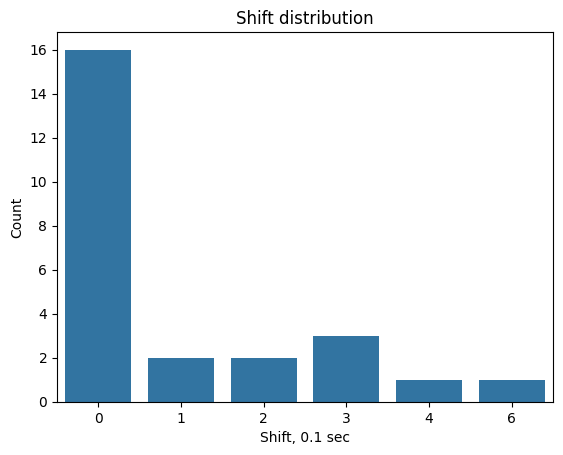

In [43]:
sns.barplot(Counter(list(map(lambda x: x[0], tau_arr_2))))
plt.xlabel("Shift, 0.1 sec")
plt.ylabel("Count")
plt.title("Shift distribution")
plt.show()

In [44]:
del cov_ts, imu_ts

### Raw data

In [24]:
eeg_tr = np.swapaxes(eeg, 1, 2)
imu_tr = np.swapaxes(imu, 1, 2)

In [25]:
lag_set = np.arange(0, 251, 25)
partial_scan_lagged_cca = partial(scan_lagged_cca, lag_set=lag_set, model='pls')

with Pool() as pool:
    tau_arr_3 = list(
        tqdm(
            pool.starmap(
                partial_scan_lagged_cca,
                zip(eeg_tr, imu_tr)
            ),
            total=len(eeg_tr)
        )
    )

  0%|          | 0/25 [00:00<?, ?it/s]

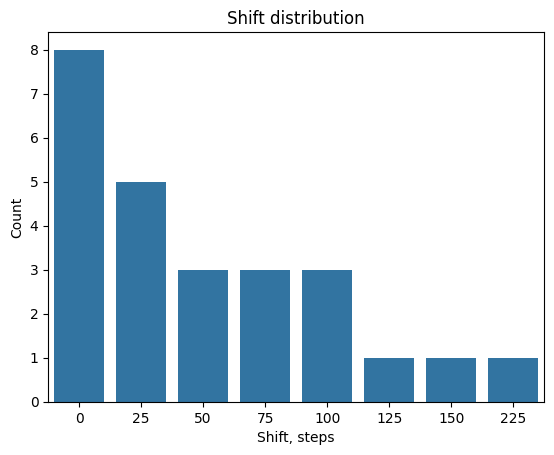

In [28]:
sns.barplot(Counter(list(map(lambda x: x[0], tau_arr_3))))
plt.xlabel("Shift, steps")
plt.ylabel("Count")
plt.title("Shift distribution")
plt.show()

**Вывод**

Для различных представлений EEG и IMU сигналов каузальный лаг находится в промежутке 0-100 ms. Это меньше 10% от длины временного окна событий. Таким образом, можно положить каузальный лаг равным 0, так как особого влияния малый ненулевой лаг не оказыавет.